<a href="https://colab.research.google.com/github/joelali5/Hate-Speech-classification-with-machine-learning/blob/main/BERT_word_embeddings_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 194 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=a58b9a82fb7c19749fbc717a7709ba466bda8e498a500ddcaec6139801c3b080
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=aa229fa5ad60fd3d1bff75c55306369f1f40c2d722a7c5428825f99ba25a42b5
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=9c1666f21c5b9a10a1260c275d64bba961fc885470bb1e003dd015cc0832595a
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow p

In [2]:
!pip install tweet-preprocessor
import pandas as pd
import numpy as np
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,Bidirectional
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import re
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import metrics
from numpy import array
import preprocessor as p

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
from collections import namedtuple
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.8.2
Hub version:  0.12.0


In [4]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

In [5]:
MAX_SEQ_LEN=240
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")

In [6]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [7]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [8]:
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [9]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\ð)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    tmpL = p.clean(line)
    # remove puctuation
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower())
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/labeled_data.csv")
# df = df.sample(frac=0.5)

df_hate = df[df['class']==0]
df_hate.shape

(1430, 7)

In [12]:
df_off = df[df['class']==1]
df_off.shape

df_off = df_off.sample(df_hate.shape[0])
df_off.shape

(1430, 7)

In [13]:
df_neither = df[df['class']==2]
df_off.shape

df_neither = df_neither.sample(df_hate.shape[0])
df_neither.shape

(1430, 7)

In [14]:
data = pd.concat([df_hate, df_off, df_neither])

In [15]:
X = clean_tweets(data["tweet"])
y = array(data['class'])

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

unique_classes = list(set(y_train))
target_classes = ["hate_speech", "offensive_language", "neither"]

In [17]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids,masks,segments

def create_input_array(sentences):

  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)

    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [30]:
import gc
from tensorflow.keras.optimizers import SGD
from keras.losses import sparse_categorical_crossentropy, binary_crossentropy, categorical_crossentropy

x = tf.keras.layers.Conv1D(240, 3, activation='relu')(sequence_output)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.expand_dims(x, axis=-1)
x = tf.keras.layers.LSTM(100, recurrent_dropout=0.2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(len(target_classes), activation="sigmoid", name="dense_output")(x)

# x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
# x = tf.keras.layers.Dropout(0.2)(x)
# out = tf.keras.layers.Dense(3, activation="sigmoid", name="dense_output")(x)

model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
opt = SGD(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 240)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 240)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 240)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 240, 768)]                'input_mask[0][0]',       

In [31]:
inputs=create_input_array(X_train)
history = model.fit(inputs,y_train,epochs=2, batch_size=32, validation_split=0.2,shuffle=True)
gc.collect()

100%|██████████| 3432/3432 [00:00<00:00, 4100.51it/s]


Epoch 1/2
86/86 [==============================] - 159s 2s/step - loss: 1.0985 - accuracy: 0.3344 - val_loss: 1.0985 - val_accuracy: 0.3217
Epoch 2/2
86/86 [==============================] - 148s 2s/step - loss: 1.0986 - accuracy: 0.3446 - val_loss: 1.0985 - val_accuracy: 0.3231


5382

In [32]:
test_inputs=create_input_array(X_test)

100%|██████████| 858/858 [00:00<00:00, 4316.04it/s]


In [34]:
from sklearn.metrics import accuracy_score, classification_report

test_preds = model.predict(test_inputs)


print("Test  Accuracy : {}".format(accuracy_score(y_test, np.argmax(test_preds, axis=1))))
print("\nClassification Report : ")
print(classification_report(y_test, np.argmax(test_preds, axis=1), target_names=target_classes, zero_division=1))

Test  Accuracy : 0.34265734265734266

Classification Report : 
                    precision    recall  f1-score   support

       hate_speech       1.00      0.00      0.00       313
offensive_language       0.35      0.99      0.51       295
           neither       0.17      0.01      0.02       250

          accuracy                           0.34       858
         macro avg       0.50      0.33      0.18       858
      weighted avg       0.53      0.34      0.18       858



In [ ]:
!pip install scikit-plot
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in y_test], [target_classes[i] for i in np.argmax(test_preds, axis=1)],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Greens",
                                    hide_zeros=False,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

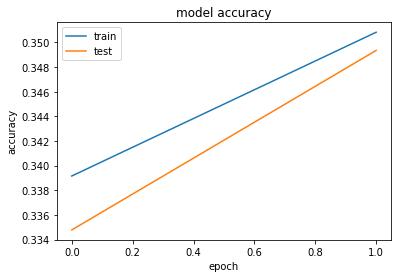

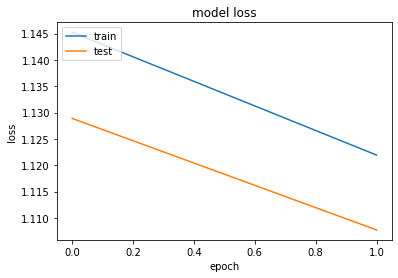

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()